# A Quick Look at Dwarf Galaxies in DELVE DR1

**This notebook is a *very lightly* adapted version of the existing dwarf galaxy science examples provided by the Astro Data Lab.
Description of these examples can be found here:**
https://datalab.noao.edu/docs/manual/UsingTheNOAODataLab/ScienceExamples/DiscoverFaintMilkyWayDwarfGalaxies/DiscoverFaintMilkyWayDwarfGalaxies.html

The original example described above, and nearly all of the code presented below, were created by Knut Olsen, Robert Nikutta, and the Astro Data Lab team. The author of this notebook's (William Cerny's) contribution is merely adapting this existing code for the newly released DELVE DR1 data. Additonally, all written description found in markdown cells is original. The intent is to provide a minimal example that uses parameters/data columns that are specific to DELVE DR1.

None of this notebook's content was reviewed or endorsed by the Astro Data Lab team. If you use this notebook for any purposes, please reference the following sources of information below:

Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

Data Lab disclaimer: https://datalab.noao.edu/disclaimers.php

# Imports

In [1]:
# std lib
from collections import OrderedDict

# 3rd party
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io, convolution, wcs
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
%matplotlib inline

from getpass import getpass
import os
import time

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# Accessing the DELVE Data through queryClient

The table this notebook utilizes is the delve_dr1.objects table. This is the first data released by the DECam Local Volume Exploration (DELVE) Survey.

In [2]:
wide_schema = 'delve_dr1'
wide_object = 'objects'

In [3]:
sql = '''SELECT * FROM {} LIMIT 10'''.format(wide_schema+'.'+wide_object)

print(sql)
df = qc.query(sql=sql,fmt='pandas')

SELECT * FROM delve_dr1.objects LIMIT 10


In [4]:
df.head()

,quick_object_id,ra,dec,hpx2048,mag_psf_g,mag_psf_r,mag_psf_i,mag_psf_z,magerr_psf_g,magerr_psf_r,...,flags_z,wavg_flags_g,wavg_flags_r,wavg_flags_i,wavg_flags_z,ring32,extended_class_g,extended_class_r,extended_class_i,extended_class_z
0,10881600051220,134.586679,-25.026484,41107194,99.0000,22.5493,20.8371,20.2003,99.000000,0.056278,...,0,99,0,0,0,8816,-9,0,0,0
1,10881600221560,134.579137,-25.026726,41107194,99.0000,99.0000,99.0000,22.4286,99.000000,99.000000,...,0,99,99,99,0,8816,-9,-9,-9,1
2,10881600006698,134.579073,-25.025375,41107194,18.1402,17.2546,16.9124,16.7193,0.002508,0.001555,...,0,0,0,0,0,8816,0,0,0,0
3,10881600051216,134.581796,-25.021410,41107194,99.0000,23.2452,21.9968,21.3196,99.000000,0.104166,...,0,99,0,0,0,8816,-9,3,1,2
4,10881600065102,134.583427,-25.021902,41107194,23.5589,22.8583,22.4939,22.3090,0.121065,0.073036,...,0,2,0,0,0,8816,3,3,3,2


### There are four known Milky Way Dwarf Satellites within the DELVE DR1 Catalogs: Hydra II, Leo IV, the Sextans Dwarf Spheroidal, and Centaurus I. The last of these systems was a DELVE discovery (see Mau et al. 2020, ApJ). The following cells use Astro Data Lab code to grab data from the delve_dr1.objects table around these four targets (using a simple cone with radius .75 degrees). 

For this notebook, only the following columns are needed: RA,DEC coordnates; MAG_AUTO photometry in the g,r bands; and spread_model_r, which is a morphological discriminant used for star/galaxy separation.

In [10]:
names = ['Hya II', 'Leo IV', 'Sextans dSph','Centaurus I']

radius = .75 # search radius in degrees

# columns to query for
columns = '''ra,dec,mag_auto_g,mag_auto_r,spread_model_r'''

In [11]:
# a function to retrieve data around a point in the sky
def getData(ra,dec,radius=.5,columns='*'):

    query_template =\
    """SELECT {0} FROM delve_dr1.objects
       WHERE q3c_radial_query(ra,dec,{1},{2},{3})"""

    query = query_template.format(columns,ra,dec,radius)
    
    try:
        result = qc.query(sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = convert(result,'pandas')
    
    return df

# gets coordinates of a named source
def resolve_coordinates(name):
    try:
        coords = name_resolve.get_icrs_coordinates(name)
    except Exception as e:
        raise

    ra = coords.ra.to('deg').value
    dec = coords.dec.to('deg').value      

    return coords, ra, dec

## Resolve the dwarf galaxy names and get their corresponding coordinates

In [12]:
dgs = OrderedDict([(name,dict()) for name in names]) # empty dictionary of dictionaries

# loop over dwarfs, resolving coordinates and querying for photometry data
for j,name in enumerate(dgs.keys()):
    print('{:s}: resolving coordinates and querying for data'.format(name))
    coords, ra0, dec0 = resolve_coordinates(name)
    dgs[name]['ra0'] = ra0
    dgs[name]['dec0'] = dec0
    df = getData(ra0,dec0,radius=radius,columns=columns)
    dgs[name]['df'] = df
print("Done.")

Hya II: resolving coordinates and querying for data
Leo IV: resolving coordinates and querying for data
Sextans dSph: resolving coordinates and querying for data
Centaurus I: resolving coordinates and querying for data
Done.


# Using the data to filter for dwarfs:

In [13]:
# create a proper WCS object
def get_wcs(ra,dec,image,fov=.4,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

# a spatial convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by Robert Nikutta.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution")

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

The cell below runs the above filter. To increase the density contrast of these faint systems against the foreground/background stellar field, a magnitude limit of 18 < g < 24 is imposed, along with a color limit of -0.5 < g-i < 1.0 was applied. For star-galaxy separation, a cut of |spread_model_r| < .003 is applied.

    Hya II: 12396
Computing differential convolution
    Leo IV: 4854
Computing differential convolution
Sextans dSph: 14179
Computing differential convolution
Centaurus I: 23287
Computing differential convolution
Done.


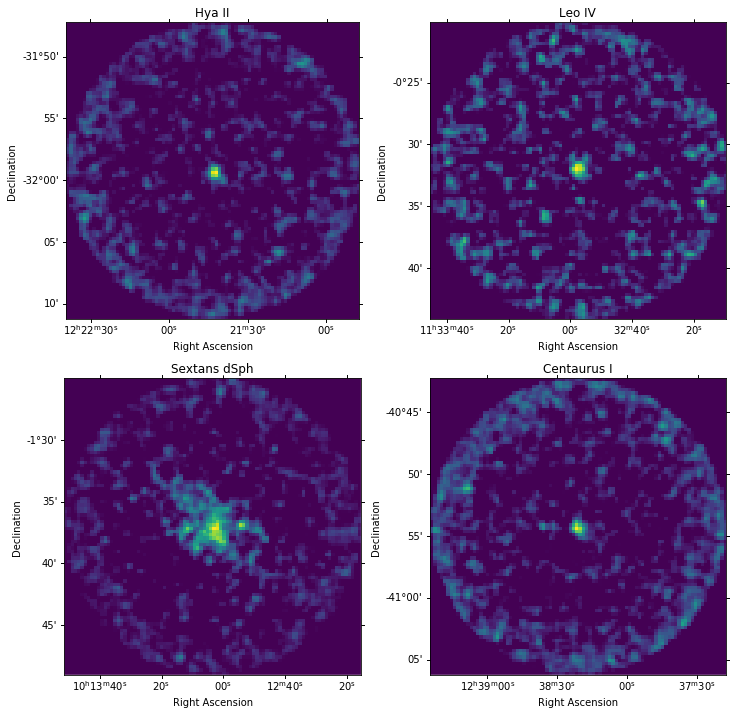

In [14]:
nrow, ncol = 2, 2  # figure layout

# common constraints
maginvalid = 24
spread = 0.003

# set up figure
fig = plt.figure(figsize=(6*ncol,6*nrow))

# loop over dwarfs
for j,name in enumerate(dgs.keys()):
    print("{:>10s}: ".format(name),end='')
    dwarf = dgs[name]
    df = dwarf['df']  # the Pandas dataframe object of current dwarf
    
    # define constraining criteria
    # (valid magnitudes, no flags, SNR>10, color range, likelihood(star) high-ish, stars fainter that gmag=18)
    keep = (df['mag_auto_g']<maginvalid) & (df['mag_auto_r']<maginvalid) &\
           ((df['mag_auto_g']-df['mag_auto_r'])>-0.5) & ((df['mag_auto_g']-df['mag_auto_r'])<1) & ((df['mag_auto_g'] > 18)) &\
           (np.abs(df['spread_model_r'])<spread)
           
    print(len(df[keep]))
    # apply constraints, and run the dwarf filter
    raw_hist, extent, delta, clipped, sigma = dwarf_filter(df['ra'][keep],df['dec'][keep])
    
    # construct a WCS
    w = get_wcs(dwarf['ra0'],dwarf['dec0'],clipped,fov=.4)
    
    # plot the clipped 2d histogram
    ax = fig.add_subplot(nrow,ncol,j+1,projection=w)
    im = plt.imshow(clipped)
    ax.set_title(name)
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')  
print("Done.")

## For a closer look at the photometry for the dwarf galaxy Centaurus I, we can plot a simple color-magnitude diagram using data from a narrow selection around the system, and compare it to a control field:

In [59]:
coords, ra0, dec0 = resolve_coordinates('Centaurus I')
cenIdf = getData(ra0,dec0,radius=.1, columns=columns)
cenIdf = cenIdf[np.abs(cenIdf['spread_model_r'] < .0032)]

In [66]:
coords, ra0, dec0 = resolve_coordinates('Centaurus I')
control = getData(ra0-.5,dec0-.6,radius=.1, columns=columns)
control = control[np.abs(control['spread_model_r'] < .0032)]

Text(0, 0.5, 'g')

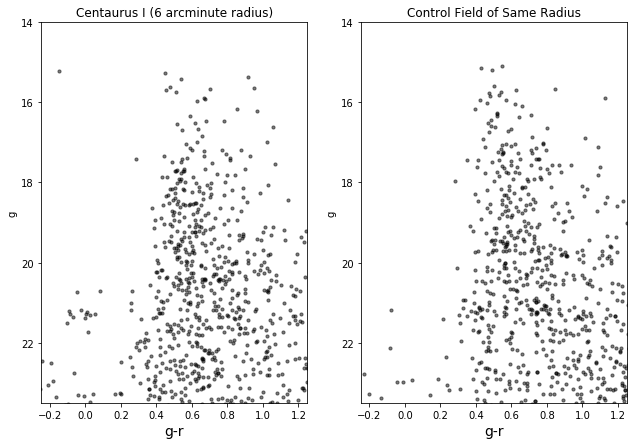

In [67]:
plt.figure(figsize = (10.5,7))
plt.subplot(1,2,1)
plt.title('Centaurus I (6 arcminute radius)')
plt.scatter(cenIdf['mag_auto_g']-cenIdf['mag_auto_r'], cenIdf['mag_auto_g'],color = 'black', alpha=  .5, s = 10)
plt.xlim(-.25,1.25)
plt.ylim(23.5,14)
plt.xlabel('g-r', fontsize = 14)
plt.ylabel('g')

plt.subplot(1,2,2)
plt.title('Control Field of Same Radius')
plt.scatter(control['mag_auto_g']-control['mag_auto_r'],control['mag_auto_g'],color = 'black', alpha=  .5, s = 10)
plt.xlim(-.25,1.25)
plt.ylim(23.5,14)
plt.xlabel('g-r', fontsize = 14)
plt.ylabel('g')

### Evidently, there are more significantly more stars in the Cen I field than in a control field of the same area. Cen I stars that are just above the main sequence turnoff (which is too faint to be seen in the DELVE data) can be seen at the faintest magnitudes. The Cen I field also contains a number of blue horizontal branch stars at g~21!